## Basis encoding with superposition would need less Qubits. 

The example down under has two data points that are being encoded. 
The following are steps involved in superposition encoding of data in basis encoding. 

A. If the number of bits of training data is 6 bits of a feature, then Processing branch + Storage branch + Ancilla Qubits = 6 + 6 + 2 = 14

B. Split the branches by using H gate on A2. 

C. Load the training vector ( all features of one training vector ) into the processing branch. 

D. Move the data to storage branch. 

E. Split the processing branch with Unitary gate which calculates $ U(\mu) = \begin{bmatrix} \sqrt\frac{\mu-1}{\mu} &\frac{1}{\sqrt\mu} \\ \frac{-1}{\sqrt\mu}& \sqrt\frac{\mu-1}{\mu} \end{bmatrix}$

F. Flip A1 for branch where loading register == storage register. 

G. Reset the storage register and loading register of both both branches.

H. Repeat from C, until all vectors are loaded.

In [96]:
## Load the first training vector
from qiskit.circuit.library import MCXGate
from qiskit import *
from qiskit.quantum_info import *
from qiskit.extensions import *
from random import randrange
import numpy
from qiskit.circuit.library import CPhaseGate

L = QuantumRegister(4, name="L")
A = QuantumRegister(2, name="A")
S = QuantumRegister(4, name="S")

C = ClassicalRegister(4)
QC = QuantumCircuit(S,A,L,C)

QC.barrier()

data = [format(randrange(1,100), "#010b")[6:] for _ in range(2)]

QC.h(A[0])
state = Statevector(QC)
state.draw(output="Latex")
m = 1
M = 2**len(data[0])
for d in data:
    print (d[::-1])
    QC.barrier()
    for i, v in enumerate(d):
        if v == '1':
            QC.x(L[i])

    for i in range(4):
        if d[i] == '1':
            QC.ccx(A[0], L[i], S[i])
    QC.barrier()

    QC.cx(A[0], A[1])
    Mu = M + 1 - m
    UMu = UnitaryGate([[math.sqrt((Mu-1)/(Mu)),1/math.sqrt(Mu)],[-1/math.sqrt(Mu),math.sqrt((Mu-1)/(Mu))]], label="UMu").control()
    QC.append(UMu, [A[1], A[0]])
    QC.barrier()

    gate = MCXGate(8)

    # ## reset the first training vector
    for i, v in enumerate(d):
        if v == '0':
            QC.x(L[i])
            QC.x(S[i])

    QC.barrier()
    QC.append(gate, [0,1,2,3,6,7,8,9,5])
    QC.barrier()

    # ## reset the first training vector
    for i, v in enumerate(d):
        if v == '0':
            QC.x(L[i])
            QC.x(S[i])

    for i, v in enumerate(d):
        if v == '1':
            QC.x(L[i])


    for i, v in enumerate(d):
        if v == '1':
            QC.cx(A[0], S[i])
    m += 1

state = Statevector(QC)
state.draw(output="Latex")

1101
1001


<IPython.core.display.Latex object>

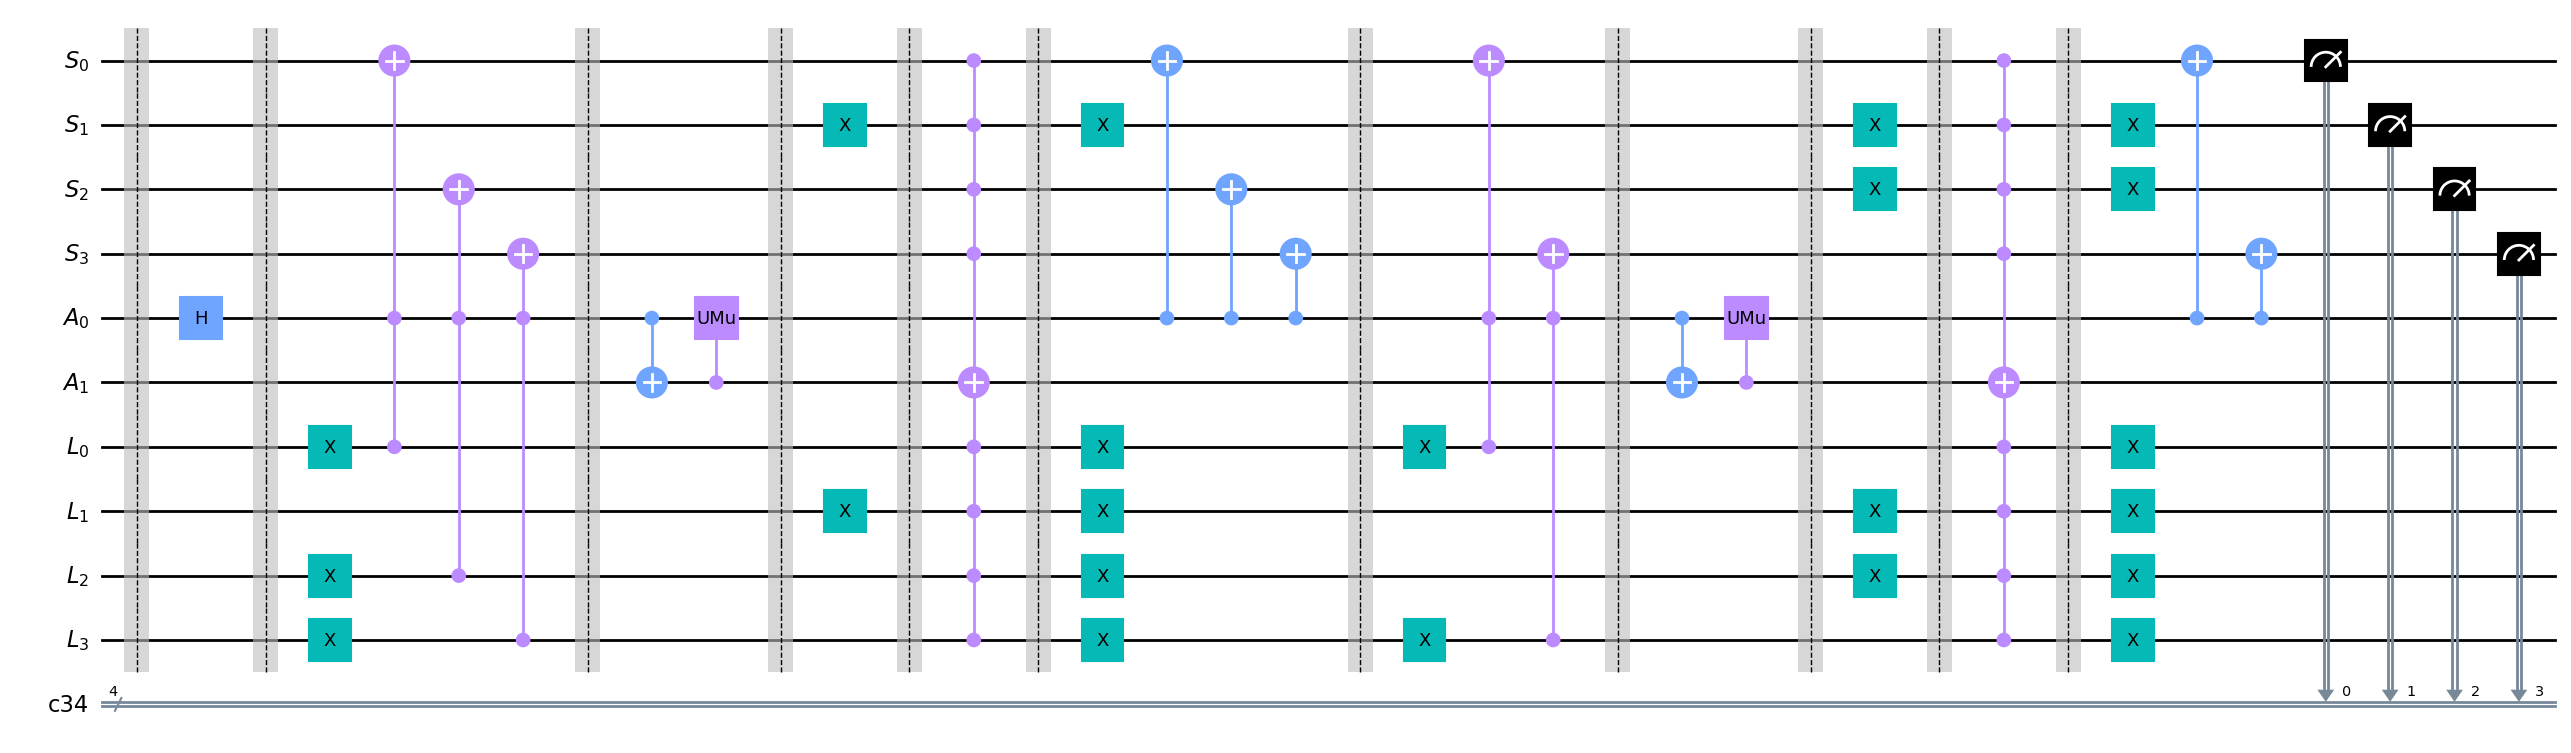

In [97]:
for i in range(4):
    QC.measure(S[i], C[i])

QC.draw(output="mpl", scale=1, fold=1000)

{'1001': 29, '1101': 30, '0000': 941}


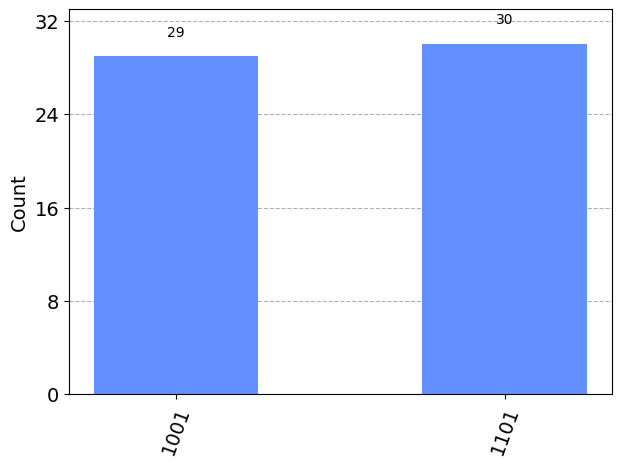

In [98]:
backend = Aer.get_backend("aer_simulator")

result = execute(QC, backend=backend, shots=1000).result()

from IPython.display import Latex
from qiskit.visualization import *

state_to_latex = result.get_counts()
print (state_to_latex)
del state_to_latex['0000']
plot_histogram(state_to_latex)